- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
from itertools import combinations

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import numpy as np
import pandas as pd
import shapely
from folium import plugins
from libpysal import graph
from scipy import sparse, spatial

from core import algorithms, utils
from core.geometry import is_within, voronoi_skeleton, snap_to_targets

In [2]:
momepy.__version__

'0.8.0a3.dev26+gefb11dd'

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_parquet_roads(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [6]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read artifacts

In [7]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [8]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [9]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [10]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [11]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [12]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Compute number of stroke groups per artifact.

In [13]:
def _get_stroke_info(artifacts, roads):
    strokes = []
    c_ = []
    e_ = []
    s_ = []
    for geom in artifacts.geometry:
        singles = 0
        ends = 0
        edges = roads.iloc[roads.sindex.query(geom, predicate="covers")]
        if (  # roundabout special case
            edges.coins_group.nunique() == 1
            and edges.shape[0] == edges.coins_count.iloc[0]
        ):
            singles = 1
            mains = 0
        else:
            all_ends = edges[edges.coins_end]
            mains = edges[
                ~edges.coins_group.isin(all_ends.coins_group)
            ].coins_group.nunique()

            visited = []
            for coins_count, group in zip(
                all_ends.coins_count, all_ends.coins_group, strict=True
            ):
                if (group not in visited) and (
                    coins_count == (edges.coins_group == group).sum()
                ):
                    singles += 1
                    visited.append(group)
                elif group not in visited:
                    ends += 1
                    # do not add to visited as they may be disjoint within the artifact
        strokes.append(edges.coins_group.nunique())
        c_.append(mains)
        e_.append(ends)
        s_.append(singles)
    return strokes, c_, e_, s_


strokes, c_, e_, s_ = _get_stroke_info(artifacts, roads)
artifacts["stroke_count"] = strokes
artifacts["C"] = c_
artifacts["E"] = e_
artifacts["S"] = s_

Filer artifacts caused by non-planar intersections.

In [14]:
artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
artifacts.iloc[np.unique(a_idx), -1] = True

Count intersititial nodes (primes).

In [15]:
artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
    axis=1
)

Define the type label.

In [16]:
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

Count the frequency of types.

In [17]:
(artifacts.ces_type.value_counts() / len(artifacts) * 100).round(1)

ces_type
3CES     19.3
2CS      16.5
1E       13.1
1S        5.0
3CEE      3.8
         ... 
5EEE      0.1
4CCEE     0.1
7S        0.1
4ES       0.1
8CS       0.1
Name: count, Length: 63, dtype: float64

Filter one type.

In [18]:
artifacts[artifacts.ces_type == "3CC"]

,geometry,face_artifact_index,id,node_count,stroke_count,C,E,S,non_planar,interstitial_nodes,ces_type
1737,"POLYGON ((681763.761 5606905.298, 681764.734 5...",2.843663,1737,3,2,2,0,0,False,1,3CC


Explore typology.

In [19]:
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# artifacts[artifacts.ces_type == "3CC"].explore(m=m, name="Artifacts", color="red")
# nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

TODO - 3CC plananrity checks

Define placeholders for generic functions fixing the issues.

In [20]:
def n1_g1_identical(edges, *, to_drop):
    """If there is only 1 continuity group {C, E, S} and only 1 node

    - drop the edge

    TODO: Maybe generate dead-end to centroid; check elongation and conditionally apply
    dead end solution (possibly hausdorff point approximation by cutting linestring in
    2; convex hull thingy)

    Parameters
    ----------
    edges : GeoDataFrame
        geometries forming the artifact
    to_drop : list
        list collecting geometries to be dropped
    """
    to_drop.append(edges.index[0])


def nx_gx_identical(edges, *, geom, to_drop, to_add, nodes):
    """If there are  1+ identical continuity groups, and more than 1 node (n>=2)

    - drop all of them and link the entry points to the centroid

    TODO: ensure all is within the artifact; proportionally to area and perimeter create
    some elongation rule and skeletonize (when there are 2 or 3 nodes we can always do
    it)

    Parameters
    ----------
    edges : GeoDataFrame
        geometries forming the artifact
    geom : shapely.Polygon
        polygonal representation of the artifact
    to_drop : list
        list collecting geometries to be dropped
    to_add : list
        list collecting geometries to be added
    nodes : GeoSeries
        nodes forming the artifact
    """
    centroid = geom.centroid
    relevant_nodes = nodes.iloc[nodes.sindex.query(geom, predicate="intersects")]

    to_drop.extend(edges.index.to_list())
    to_add.extend(shapely.shortest_line(relevant_nodes, centroid).to_list())


def nx_gx(edges, *, artifact, to_drop, to_add, roads, nodes):
    """
    Drop all but highest hierarchy. If there are unconnected nodes after drop, connect
    to nearest remaining edge or nearest intersection if there are more remaining edges.
    If there three or more of the highest hierarchy, use roundabout solution.

    If, after dropping, we end up with more than one connected components based on
    remaining edges, create a connection either as a shortest line between the two or
    using skeleton if that is not inside or there are 3 or more components.

    Connection point should ideally be an existing nearest node with degree 4 or above.
    """
    highest_hierarchy = "C" if artifact["C"] > 0 else "E"
    if highest_hierarchy == "C":
        all_ends = edges[edges.coins_end]
        es_mask = edges.coins_group.isin(all_ends.coins_group)
        highest_hierarchy = edges[~es_mask]
        # ends_simples
        to_drop.extend(edges)

## To-do:

- Resolve snapping to a line by splitting it.
- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.
- List of issues identified by Ana on GH
- no C

## WIP

Section below is dev code which will likely significantly change.

`highest_hierarchy == "C"`

In [24]:
# TODO - check this
artifact = artifacts.sample(1).iloc[0]

Below is a draft of the `nx_gx` function.

CONDITION n_comps > 1 True
CONDITION relevant_targets.shape[0] > 0 False, snapping to C
CONDITION remaining_nodes.shape[0] < 2 True


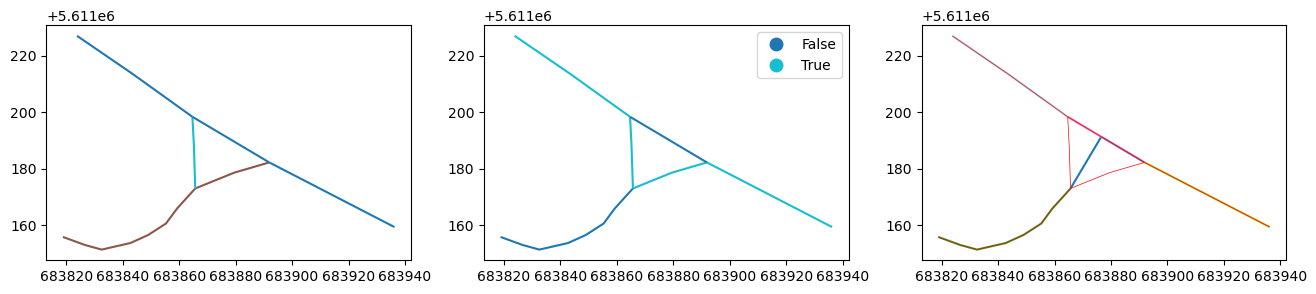

In [69]:
# for i, artifact in artifacts[(artifacts.C == 0) & (artifacts.E > 0) & (artifacts.S > 0)].iterrows():
#     print(i)

# define parameter used for segmentation and other derived steps
distance = 2

# collect changes
to_drop = []
to_add = []

# get edges relevant for an artifact
edges = roads.iloc[roads.sindex.query(artifact.geometry, predicate="covers")]

# filter ends
all_ends = edges[edges.coins_end]

if artifact.C > 0:
    # define mask for E and S strokes
    es_mask = edges.coins_group.isin(all_ends.coins_group)
    # filter Cs
    highest_hierarchy = edges[~es_mask]
else:
    singles = set()
    visited = []
    for coins_count, group in zip(
        all_ends.coins_count, all_ends.coins_group, strict=True
    ):
        if (group not in visited) and (
            coins_count == (edges.coins_group == group).sum()
        ):
            singles.add(group)
            visited.append(group)
    # filter ends
    all_ends = edges[edges.coins_group.isin(singles)]
    # define mask for E and S strokes
    es_mask = edges.coins_group.isin(all_ends.coins_group)
    # filter Cs
    highest_hierarchy = edges[~es_mask]
# get nodes forming the artifact
relevant_nodes = nodes.iloc[
    nodes.sindex.query(artifact.geometry, predicate="dwithin", distance=1e-6)
]
# filter nodes that lie on Cs (possibly primes)
nodes_on_cont = relevant_nodes.index[
    relevant_nodes.sindex.query(
        highest_hierarchy.geometry.union_all(), predicate="dwithin", distance=1e-6
    )
]
# get nodes that are not on Cs
remaining_nodes = relevant_nodes.drop(nodes_on_cont)

# get all remaining geometries and determine if they are all connected or new
# connections need to happen
remaining_geoms = pd.concat([remaining_nodes.geometry, highest_hierarchy.geometry])
heads_ix, tails_ix = remaining_geoms.sindex.query(
    remaining_geoms, predicate="intersects"
)
n_comps = graph.Graph.from_arrays(heads_ix, tails_ix, 1).n_components

# add list of existing edges to be removed from the network
to_drop.extend(edges[es_mask].index.tolist())
if n_comps > 1:
    print("CONDITION n_comps > 1 True")

    # get nodes that are relevant snapping targets (degree 4+)
    relevant_targets = relevant_nodes.loc[nodes_on_cont].query("degree > 3")

    cont_comp_labels = graph.Graph.build_contiguity(
        highest_hierarchy, rook=False
    ).component_labels
    conts_groups = highest_hierarchy.dissolve(cont_comp_labels)

    # BRANCH 1 - multiple Cs
    if len(highest_hierarchy) > 1:
        print("CONDITION len(highest_hierarchy) > 1 True")

        # Get nodes on Cs
        bd_points = highest_hierarchy.boundary.explode()
        # Identify nodes on primes
        primes = bd_points[bd_points.duplicated()]

        # For CCSS we need a special case solution if the lenght of S is significantly
        # shorter than the lenght of C. In that case, Voronoi does not create shortest
        # connections but a line that is parallel to Cs.
        if (
            highest_hierarchy.coins_group.nunique() == 2
            and artifact.S == 2
            and (highest_hierarchy.length.sum() > all_ends.length.sum())
        ):
            print("CONDITION for CCSS special case True")

            # If there are primes on both Cs, connect them. If there's prime on one C,
            # connect it to the other C. If there are no primes, get midpoints on Cs and
            # connect those.
            if primes.empty:
                # midpoints solution
                c0 = conts_groups.geometry.iloc[0]
                c1 = conts_groups.geometry.iloc[1]
                p0 = shapely.line_interpolate_point(c0, 0.5, normalized=True)
                p1 = shapely.line_interpolate_point(c1, 0.5, normalized=True)
                new_connections = [shapely.LineString([p0, p1])]

            # one prime, get shortest line to the other C
            elif primes.shape[0] == 1:
                no_prime_c = conts_groups[
                    conts_groups.disjoint(primes.geometry.item())
                ]
                new_connections = [
                    shapely.shortest_line(
                        primes.geometry.item(), no_prime_c.geometry.item()
                    )
                ]

            # two primes, connect them
            elif primes.shape[0] == 2:
                new_connections = [
                    shapely.shortest_line(
                        primes.geometry.iloc[0], primes.geometry.iloc[1]
                    )
                ]

            # multiple primes, connect two nearest on distinct Cs
            else:
                primes_on_c0 = primes[
                    primes.interesects(conts_groups.geometry.iloc[0])
                ]
                primes_on_c1 = primes[
                    primes.interesects(conts_groups.geometry.iloc[1])
                ]
                new_connections = [
                    shapely.shortest_line(
                        primes_on_c0.union_all(), primes_on_c1.union_all()
                    )
                ]

            # some nodes may have ended unconnected. Find them and reconnect them.
            combined_linework =pd.concat([highest_hierarchy, gpd.GeoSeries(new_connections, crs=highest_hierarchy.crs)]).union_all()
            missing = relevant_nodes[relevant_nodes.disjoint(combined_linework)]
            new_connections.extend(shapely.shortest_line(missing.geometry, combined_linework).tolist())

        else:
            print("CONDITION for CCSS special case False")

            # Get new connections via skeleton
            new_connections, splitters = voronoi_skeleton(
                edges.geometry,  # use all edges as an input
                poly=artifact.geometry,
                snap_to=relevant_targets.geometry,  # snap to nodes
                distance=distance,
                # buffer = highest_hierarchy.length.sum() * 1.2
            )
            nc = new_connections

            # The skeleton returns connections to all the nodes. We need to keep only
            # some, if there are multiple connections to a single C. We don't touch
            # the other.

            unwanted = []
            keeping = []
            for c in conts_groups.geometry:
                int_mask = shapely.intersects(new_connections, c)
                connections_intersecting_c = new_connections[int_mask]
                if len(connections_intersecting_c) > 1:
                    prime_mask = shapely.intersects(
                        connections_intersecting_c, primes.union_all()
                    )
                    connections_intersecting_primes = connections_intersecting_c[
                        prime_mask
                    ]
                    # if there are multiple connections to a single C, drop them and keep only the shortest one
                    # leading to prime
                    if (
                        len(connections_intersecting_c) > 1
                        and len(connections_intersecting_primes) > 0
                    ):
                        lens = shapely.length(connections_intersecting_primes)
                        unwanted.append(connections_intersecting_c)
                        keeping.append(
                            connections_intersecting_primes[[np.argmin(lens)]]
                        )

                    # fork on two nodes on C
                    # elif len(connections_intersecting_c) > 1:
                    #     unwanted.append(connections_intersecting_c)

            if len(unwanted) > 0:
                if len(keeping) > 0:
                    new_connections = np.concatenate(
                        [
                            new_connections[
                                ~np.isin(new_connections, np.concatenate(unwanted))
                            ],
                            np.concatenate(keeping),
                        ]
                    )
                else:
                    new_connections = new_connections[
                        ~np.isin(new_connections, np.concatenate(unwanted))
                    ]

            # mutliple Cs that are not intersecting. Avoid forks on the ends of Voronoi. If
            # one goes to relevant node, keep it. If not, remove both and replace with
            # a new shortest connection
            if (
                len(connections_intersecting_c) > 1
                and len(connections_intersecting_primes) == 0
            ):
                int_mask = shapely.intersects(
                    new_connections, highest_hierarchy.union_all()
                )
                targets_mask = shapely.intersects(
                    new_connections, relevant_targets.union_all()
                )
                connections_intersecting_targets = new_connections[targets_mask]
                new_connections = new_connections[
                    (int_mask * targets_mask) | np.invert(int_mask)
                ]
                cont_diss = highest_hierarchy.dissolve(highest_hierarchy.coins_group).geometry
                addition = snap_to_targets(
                    new_connections,
                    artifact.geometry,
                    cont_diss[
                        cont_diss.disjoint(shapely.union_all(new_connections))
                    ],
                )
                new_connections = np.concatenate([new_connections, addition])

            # check for disconnected Cs and reconnect
            new_connections_comps = graph.Graph.build_contiguity(
                gpd.GeoSeries(new_connections), rook=False
            ).component_labels
            new_components = gpd.GeoDataFrame(geometry=new_connections).dissolve(
                new_connections_comps
            )
            additions = []
            for c in conts_groups.geometry:
                mask = new_components.intersects(c)
                if not mask.all():
                    additions.extend(
                        snap_to_targets(
                            new_components[~mask].geometry, artifact.geometry, [c]
                        )
                    )
            if len(additions) > 0:
                print("CONDITION len(disconnected_cs) > 0 True")

                new_connections = np.concatenate([new_connections, additions])

            new_connections = shapely.line_merge(new_connections)
            # the drop above could've introduced a dangling edges. Remove those.
            dangling = []
            pts0 = shapely.get_point(new_connections, 0)
            pts1 = shapely.get_point(new_connections, -1)
            pts = shapely.buffer(np.concatenate([pts0, pts1]), 1e-6)
            all_idx, pts_idx = shapely.STRtree(pts).query(
                np.concatenate([pts, [artifact.geometry.boundary]]),
                predicate="intersects",
            )
            data = [True] * len(all_idx)
            sp = sparse.coo_array(
                (data, (pts_idx, all_idx)), shape=(len(pts), len(pts) + 1)
            )
            dangles = pts[sp.sum(axis=1) == 1]
            new_connections = new_connections[
                shapely.disjoint(new_connections, shapely.union_all(dangles))
            ]

    # BRANCH 2 - relevant node targets exist
    elif relevant_targets.shape[0] > 0:
        print("CONDITION relevant_targets.shape[0] > 0 True")

        # SUB BRANCH - only one remaining node
        if remaining_nodes.shape[0] < 2:
            print("CONDITION remaining_nodes.shape[0] < 2 True")

            # find the nearest relevant target
            remaining_nearest, target_nearest = relevant_targets.sindex.nearest(
                remaining_nodes.geometry, return_all=False
            )
            # create a new connection as the shortest straight line
            new_connections = shapely.shortest_line(
                remaining_nodes.geometry.iloc[remaining_nearest].values,
                relevant_targets.geometry.iloc[target_nearest].values,
            )
            # check if the new connection is within the artifact
            connections_within = is_within(new_connections, artifact.geometry, 0.1)
            # if it is not within, discard it and use the skeleton instead
            if not connections_within.all():
                print("CONDITION is_within False")

                new_connections, splitters = voronoi_skeleton(
                    edges[es_mask].geometry,  # use edges that are being dropped
                    poly=artifact.geometry,
                    snap_to=relevant_targets.geometry,  # snap to relevant node targets
                    distance=distance,
                    buffer=distance,  # TODO: figure out if we need this
                )

        # SUB BRANCH - more than one remaining node
        else:
            print("CONDITION remaining_nodes.shape[0] < 2 False")

            # use skeleton to ensure all nodes are naturally connected
            new_connections, splitters = voronoi_skeleton(
                edges[es_mask].geometry,  # use edges that are being dropped
                poly=artifact.geometry,
                snap_to=relevant_targets.geometry,  # snap to relevant node targets
                distance=distance,
                secondary_snap_to=highest_hierarchy.geometry,
                # buffer = highest_hierarchy.length.sum() * 1.2
            )

            new_connections = shapely.line_merge(new_connections)
            # the drop above could've introduced a dangling edges. Remove those.
            dangling = []
            pts0 = shapely.get_point(new_connections, 0)
            pts1 = shapely.get_point(new_connections, -1)
            pts = shapely.buffer(np.concatenate([pts0, pts1]), 1e-6)
            all_idx, pts_idx = shapely.STRtree(pts).query(
                np.concatenate([pts, [artifact.geometry.boundary]]),
                predicate="intersects",
            )
            data = [True] * len(all_idx)
            sp = sparse.coo_array(
                (data, (pts_idx, all_idx)), shape=(len(pts), len(pts) + 1)
            )
            dangles = pts[sp.sum(axis=1) == 1]
            new_connections = new_connections[
                shapely.disjoint(new_connections, shapely.union_all(dangles))
            ]


    # BRANCH 3 - no target nodes - snapping to C
    else:
        print("CONDITION relevant_targets.shape[0] > 0 False, snapping to C")

        # SUB BRANCH - only one remaining node
        if remaining_nodes.shape[0] < 2:
            print("CONDITION remaining_nodes.shape[0] < 2 True")

            # create a new connection as the shortest straight line to any C
            new_connections = shapely.shortest_line(
                remaining_nodes.geometry.values,
                highest_hierarchy.union_all(),
            )
            splitters = shapely.get_point(new_connections,-1)
            # check if the new connection is within the artifact
            connections_within = is_within(new_connections, artifact.geometry, 0.1)
            # if it is not within, discard it and use the skeleton instead
            if not connections_within.all():
                print("CONDITION is_within False")

                new_connections, splitters = voronoi_skeleton(
                    edges[es_mask].geometry,  # use edges that are being dropped
                    poly=artifact.geometry,
                    snap_to=highest_hierarchy.dissolve(
                        "coins_group"
                    ).geometry,  # snap to Cs
                    distance=distance,
                    # buffer = highest_hierarchy.length.sum() * 1.2
                )
                nc = new_connections

        # SUB BRANCH - more than one remaining node
        else:
            print("CONDITION remaining_nodes.shape[0] < 2 False")

            # use skeleton to ensure all nodes are naturally connected
            new_connections, splitters = voronoi_skeleton(
                edges[es_mask].geometry,  # use edges that are being dropped
                poly=artifact.geometry,
                snap_to=highest_hierarchy.dissolve("coins_group").geometry,  # snap to Cs
                distance=distance,
                # buffer = highest_hierarchy.length.sum() * 1.2
            )
            nc = new_connections

        # check for disconnected Cs and reconnect
        new_connections_comps = graph.Graph.build_contiguity(
            gpd.GeoSeries(new_connections), rook=False
        ).component_labels
        new_components = gpd.GeoDataFrame(geometry=new_connections).dissolve(
            new_connections_comps
        )
        additions = []
        for c in conts_groups.geometry:
            mask = new_components.intersects(c)
            if not mask.all():
                additions.extend(
                    snap_to_targets(
                        new_components[~mask].geometry, artifact.geometry, [c]
                    )
                )
        if len(additions) > 0:
            print("CONDITION len(disconnected_cs) > 0 True")

            new_connections = np.concatenate([new_connections, additions])

    # add new connections to a list of features to be added to the network
    to_add.extend(list(new_connections))

# there may be loops or half-loops we are dropping. If they are protruding enough
# we want to replace them by a deadend representing their space
elif artifact.C == 1 and (artifact.E + artifact.S) == 1:
    print("CONDITION is_loop True")

    # check if we need to add a deadend to represent the space
    dropped = edges[es_mask].geometry.item()
    segments = list(
        map(
            shapely.LineString,
            zip(dropped.coords[:-1], dropped.coords[1:], strict=True),
        )
    )  # TODO: vectorize this shit

    # figure out if there's a snapping node
    # Get nodes on Cs
    bd_points = highest_hierarchy.boundary.explode()
    # Identify nodes on primes
    primes = bd_points[bd_points.duplicated()]
    # # if primes.empty:
    snap_to = highest_hierarchy.dissolve("coins_group").geometry
    # else:
    #     snap_to = [primes.union_all()]

    possible_dangle, splitters = voronoi_skeleton(
        segments,  # use edges that are being dropped
        poly=artifact.geometry,
        snap_to=snap_to,
        distance=distance,
        # buffer = highest_hierarchy.length.sum() * 1.2
    )
    dn = possible_dangle
    possible_dangle = possible_dangle[shapely.disjoint(possible_dangle, dropped)]
    if (
        graph.Graph.build_contiguity(
            gpd.GeoSeries(possible_dangle), rook=False
        ).n_components
        == 1
    ):
        dangle_coins = momepy.COINS(
            gpd.GeoSeries(shapely.line_merge(possible_dangle)).explode(),
            flow_mode=True,
        ).stroke_gdf()
        candidate = dangle_coins.loc[dangle_coins.length.idxmax()].geometry
        if candidate.intersects(snap_to.union_all().buffer(1e-6)):
            to_add.append(candidate)



cleaned_roads = roads.geometry.drop(to_drop)
# split lines on new nodes
for split in splitters:
    _, ix = cleaned_roads.sindex.nearest(split, max_distance=1e-6)
    edge = cleaned_roads.geometry.iloc[ix]
    snapped = shapely.snap(edge.item(), split, tolerance=1e-6)
    lines_split = shapely.get_parts(shapely.ops.split(snapped, split))
    cleaned_roads = pd.concat([cleaned_roads.drop(edge.index[0]), gpd.GeoSeries(lines_split, crs=roads.crs)])

# create new roads with fixed geometry. Note that to_add and to_drop lists shall be
# global and this step should happen only once, not for every artifact
new_roads = pd.concat(
    [
        cleaned_roads,
        gpd.GeoSeries(to_add, crs=roads.crs).line_merge().simplify(distance),
    ]
)




# plot the results for visual verification
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
geom = artifact.geometry
# geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
# geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot(
    "coins_end", ax=axs[1], categorical=True, legend=True
)
new_roads.clip(geom.buffer(50)).plot(ax=axs[2], zorder=2, cmap="tab20")
roads.clip(geom.buffer(50)).plot(
    color="red", ax=axs[2], categorical=True, legend=True, linewidth=0.5
)
plt.show()

In [49]:
split = splitters[0]

In [65]:
lines_split

array([<LINESTRING (683864.666 5611198.444, 683876.559 5611191.384)>,
       <LINESTRING (683876.559 5611191.384, 683891.893 5611182.28)>],
      dtype=object)

<Axes: >

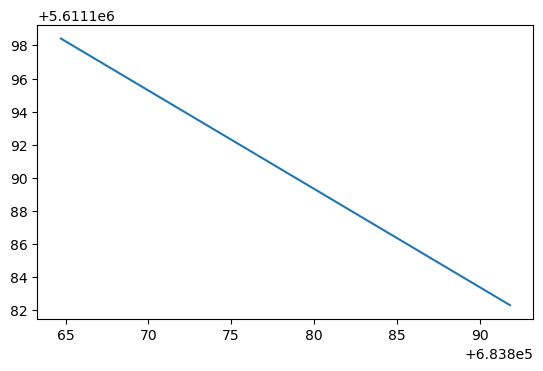

In [66]:
gpd.GeoSeries(lines_split).plot()

In [67]:
m = gpd.GeoSeries(to_add).explore(
    opacity=0.5, max_zoom=52, highlight_kwds=dict(color="red")
)
# edges.set_crs(None, allow_override=True).explore(m=m, color="red", highlight_kwds=dict(color="black"))
gpd.GeoSeries(splitters).explore(m=m, marker_type="marker")
gpd.GeoSeries(lines_split).explore(m=m, color="red", highlight_kwds=dict(color="black"))
dangle_coins.explore(m=m, color='black')
m


In [44]:
remaining_nodes

,x,y,degree,nodeID,geometry
9372,688539.871285,5.621564e+06,3,9372,POINT (688539.871 5621563.832)


In [45]:
nodes_on_cont

Index([2809, 2808], dtype='int64')

### code from core.geometry.voronoi_skeleton for debugging purposes

In [53]:
# parameters being passed to voronoi_skeleton
lines = edges[es_mask].geometry
poly = artifact.geometry
snap_to = highest_hierarchy.dissolve("coins_group").geometry
distance = 2
# buffer = highest_hierarchy.length.sum() * 1.2
buffer = None

In [66]:
if buffer is None:
    buffer = distance * 20
if not poly:
    poly = shapely.box(*lines.total_bounds)
# get an additional line around the lines to avoid infinity issues with Voronoi
extended_lines = list(lines) + [poly.buffer(buffer).exterior]

# interpolate lines to represent them as points for Voronoi
shapely_lines = extended_lines
points, ids = shapely.get_coordinates(
    shapely.segmentize(shapely_lines, distance / 2), return_index=True
)

# remove duplicated coordinates
unq, count = np.unique(points, axis=0, return_counts=True)
mask = np.isin(points, unq[count > 1]).all(axis=1)
points = points[~mask]
ids = ids[~mask]

# generate Voronoi diagram
voronoi_diagram = spatial.Voronoi(points)

# get all rigdes and filter only those between the two lines
pts = voronoi_diagram.ridge_points
mapped = np.take(ids, pts)
rigde_vertices = np.array(voronoi_diagram.ridge_vertices)

# iterate over segment-pairs and keep rigdes between input geometries
edgelines = []
to_add = []
dist = min([distance, shapely.ops.polylabel(poly).distance(poly.boundary) * .4])
limit = poly.buffer(-dist)
for a, b in combinations(range(len(lines)), 2):
    mask = (
        np.isin(mapped[:, 0], [a, b])
        & np.isin(mapped[:, 1], [a, b])
        & (mapped[:, 0] != mapped[:, 1])
    )
    verts = rigde_vertices[mask]

    # generate the line in between the lines
    edgeline = shapely.line_merge(
        shapely.multilinestrings(voronoi_diagram.vertices[verts])
    )

    # check if the edgeline is within polygon
    if not edgeline.within(poly):
        # if not, clip it by the polygon with a small negative buffer to keep the
        # gap between edgeline and poly boundary to avoid possible overlapping lines
        edgeline = shapely.intersection(edgeline, limit)

    # check if a, b lines share a node
    intersection = shapely_lines[b].intersection(shapely_lines[a])
    # if they do, add shortest line from the edgeline to the shared node and combine
    # it with the edgeline
    if not intersection.is_empty:
        # we need union of edgeline and shortest because snap is buggy in GEOS and
        # line_merge as well. This results in a MultiLineString but we can deal
        # with those later. For now, we just need this extended edgeline to be a
        # single geometry to ensure the component discovery below works as intended
        edgeline = shapely.union(
            edgeline, shapely.shortest_line(edgeline.boundary, intersection)
        )
    # add final edgeline to the list
    edgelines.append(edgeline)

e_ = edgelines
edgelines = np.array(edgelines)[~(shapely.is_empty(edgelines))]

if edgelines.shape[0] > 0:
    # if there is no explicit snapping target, snap to the boundary of the polygon
    # via the shortest line. That is by definition always within the polygon
    # (I think)
    if snap_to is None:
        to_add.append(
            shapely.shortest_line(
                shapely.union_all(edgelines).boundary, poly.boundary
            )
        )

    # if we have some snapping targets, we need to figure out
    # what shall be snapped to what
    else:
        to_add.extend(snap_to_targets(edgelines, poly, snap_to))

    # concatenate edgelines and their additions snapping to edge
    edgelines = np.concatenate([edgelines, to_add])
    # simplify to avoid unnecessary point density and some wobbliness
    edgelines = shapely.simplify(edgelines, distance / 2)
# drop empty
edgelines = edgelines[edgelines != None]  # noqa: E711
# TODO: shall we try calling line_merge before returning? It was working weirdly in
# TODO: some occasions
    # return edgelines[shapely.length(edgelines) > 0]


def snap_to_targets(edgelines, poly, snap_to):
    to_add = []
    # cast edgelines to gdf
    edgelines_df = gpd.GeoDataFrame(geometry=edgelines)
    # build queen contiguity on edgelines and extract component labels
    comp_labels = graph.Graph.build_contiguity(
        edgelines_df[~(edgelines_df.is_empty | edgelines_df.geometry.isna())],
        rook=False,
    ).component_labels
    # compute size of each component
    comp_counts = comp_labels.value_counts()
    # get MultiLineString geometry per connected component
    components = edgelines_df.dissolve(comp_labels)

    # if there are muliple components, loop over all and treat each
    if len(components) > 1:
        for comp_label, comp in components.geometry.items():
            # if component does not intersect the boundary, it needs to be snapped
            # if it does but has only one part, this part interesect only on one
            # side (the node remaining from the removed edge) and needs to be
            # snapped on the other side as well
            # print(comp.intersects(poly.boundary), comp_counts[comp_label] == 1)
            if (not comp.intersects(poly.boundary)) or comp_counts[comp_label] == 1:
                # add segment composed of the shortest line to the nearest snapping
                # target. We use boundary to snap to endpoints of edgelines only
                to_add.append(
                    shapely.shortest_line(shapely.union_all(snap_to), comp.boundary)
                )
    else:
        # if there is a single component, ensure it gets a shortest line to an
        # endpoint from each snapping target
        # TODO: verify that this is correct, writing it I realised that it may
        # TODO: be wrong
        for target in snap_to:
            to_add.append(shapely.shortest_line(target, components.boundary.item()))
    return to_add


True True
True True


/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [67]:
to_add

[<LINESTRING (688835.214 5610412.802, 688833.835 5610411.353)>,
 <LINESTRING (688866.014 5610383.491, 688864.636 5610382.042)>]

In [68]:
m = edges.explore(color="red", tiles=None,  highlight_kwds=dict(color="black"))
gpd.GeoSeries(edgelines, crs=edges.crs).explore(m=m)
gpd.GeoSeries(to_add, crs=edges.crs).explore(m=m, color="green")

m